In [1]:
#모듈 임포트
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision import transforms , models , datasets
from PIL import Image
import os
import glob
from tqdm import tqdm  # tqdm 임포트
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.font_manager as fm
import random
from torch.utils.data import random_split
from sklearn.model_selection import KFold

In [2]:
# 나눔글꼴 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)

In [3]:
# CUDA 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 데이터셋 클래스 정의
class LipReadingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.sequences = []
        self.labels = []
        self.sequence_length = 10  # 시퀀스 길이 고정
        self._load_data()

    def _load_data(self):
            for word in os.listdir(self.data_dir):
                word_path = os.path.join(self.data_dir, word)
                if os.path.isdir(word_path):
                    for speaker in os.listdir(word_path):
                        speaker_path = os.path.join(word_path, speaker)
                        if os.path.isdir(speaker_path):
                            for seq in os.listdir(speaker_path):
                                seq_path = os.path.join(speaker_path, seq)
                                if os.path.isdir(seq_path):
                                    sequence_images = sorted(glob.glob(os.path.join(seq_path, '*.jpg')))
                                    if len(sequence_images) >= 5:  # 최소 5장의 이미지가 있는 시퀀스만 사용
                                        self.sequences.append(sequence_images)
                                        self.labels.append(word)


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        image_paths = self.sequences[idx]
        images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
        
        # 시퀀스 길이를 고정
        if len(images) < self.sequence_length:
            images += [images[-1]] * (self.sequence_length - len(images))  # 마지막 이미지를 반복하여 채우기
        elif len(images) > self.sequence_length:
            images = images[:self.sequence_length]  # 처음 10개의 이미지만 사용
        
        if self.transform:
            images = [self.transform(image) for image in images]
        
        # 시퀀스 이미지를 텐서로 변환하고 하나의 텐서로 결합
        images_tensor = torch.stack(images)
        
        label = self.labels[idx]
        return images_tensor, label

In [5]:
# 데이터 전처리
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])
# 학습 데이터 변환 정의
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])

# 검증 데이터 변환 정의
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])



In [6]:

data_dir = 'dataset/trainset'  # 데이터 경로
full_dataset = LipReadingDataset(data_dir)

train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset,val_dataset = random_split(full_dataset,[train_size,val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transfrom = val_transform

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset,batch_size=4,shuffle=False,num_workers=2)

In [7]:
# 레이블을 정수로 변환하는 매핑 생성
label_to_idx = {label: idx for idx, label in enumerate(set(full_dataset.labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [8]:
idx_to_label

{0: '애',
 1: '우',
 2: '워',
 3: '마',
 4: '왠',
 5: '여',
 6: '오',
 7: '어',
 8: '임',
 9: '안',
 10: '아',
 11: '으'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

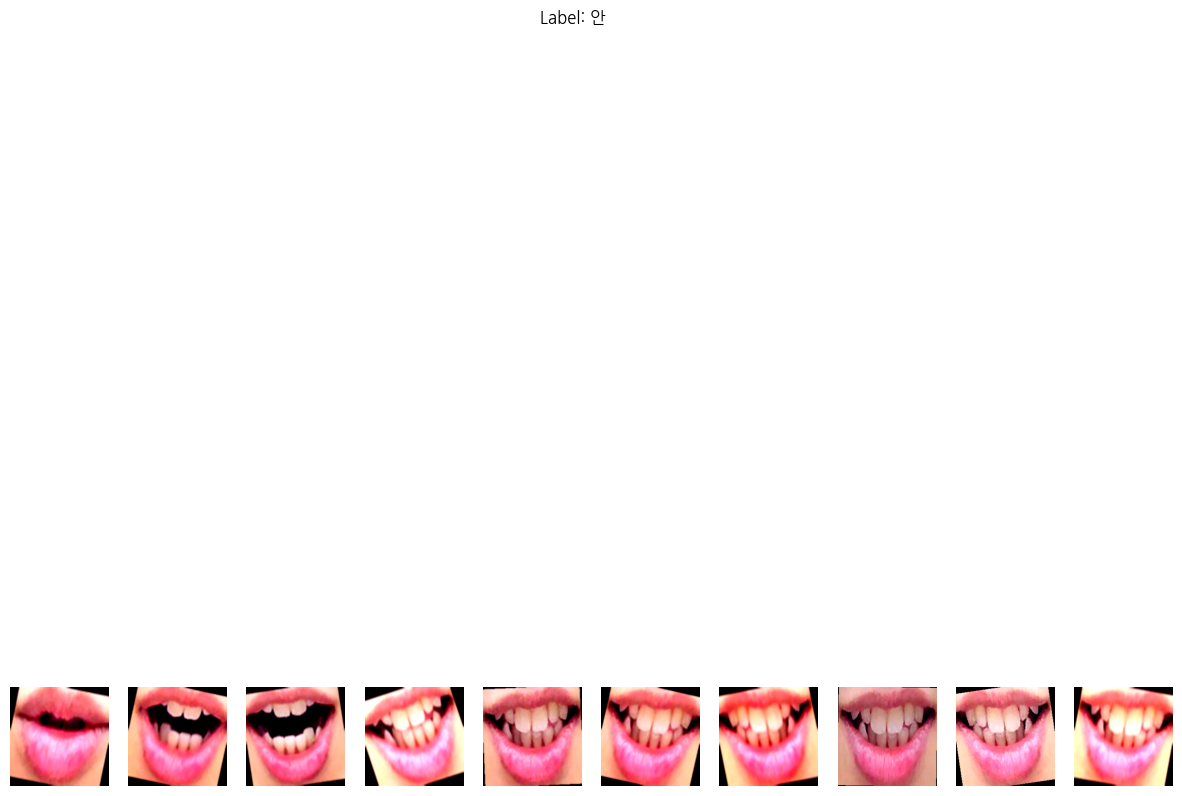

In [9]:
def visualize_sample(sample, label):
    images = sample.permute(0, 1, 2, 3)  # (T, C, H, W) -> (T, C, H, W)

    fig, axes = plt.subplots(1, len(images), figsize=(15, 15))
    fig.suptitle(f'Label: {label}')
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0)  # 정규화 해제 (C, H, W) -> (H, W, C)
        img = img * 0.5 + 0.5  # 정규화 해제
        axes[idx].imshow(img.numpy())
        axes[idx].axis('off')
    plt.show()

sample, label = full_dataset[0]
visualize_sample(sample, label)

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# MobileNetV2 + LSTM + Dropout 모델 정의
class MobileNetV2LSTM(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.6):
        super(MobileNetV2LSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        mobilenet.features = nn.Sequential(
            *list(mobilenet.features),
            nn.AdaptiveAvgPool2d((1, 1))  # 추가: AdaptiveAvgPool2d로 마지막 출력 크기를 (1, 1)로 만듦
        )
        self.mobilenet = mobilenet.features
        self.lstm = nn.LSTM(1280, 256, batch_first=True)  # MobileNetV2의 출력 크기 1280
        self.dropout = nn.Dropout(dropout_rate)  # Dropout 레이어 추가
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.mobilenet(x).squeeze(-1).squeeze(-1)  # (batch_size * seq_length, 1280, 1, 1) -> (batch_size * seq_length, 1280)
        x = x.view(batch_size, seq_length, -1)
        x, _ = self.lstm(x)
        x = self.dropout(x)  # Dropout 적용
        x = self.fc(x[:, -1, :])
        return x

In [11]:
# 평가 함수 정의
def evaluate_model(model, dataloader, label_to_idx, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    unknown_label_idx = num_classes  # Unknown label index
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = [label_to_idx.get(label, unknown_label_idx) for label in labels]  # Unknown label handling
            valid_indices = [i for i, label in enumerate(labels) if label != unknown_label_idx]
            
            if valid_indices:  # 유효한 인덱스가 있을 때만 평가
                images = images[valid_indices]
                labels = torch.tensor([label for label in labels if label != unknown_label_idx], dtype=torch.long).to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
    if all_labels and all_preds:
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    else:
        accuracy = 0.0
        cm = np.zeros((num_classes, num_classes), dtype=int)
    
    return accuracy, cm, all_preds, all_labels

In [12]:
# 혼동 행렬을 20개의 라벨씩 나누는 함수 정의
def plot_confusion_matrix_in_chunks(cm, idx_to_label, chunk_size=20):
    labels = list(idx_to_label.values())
    num_labels = len(labels)
    
    for i in range(0, num_labels, chunk_size):
        chunk_labels = labels[i:i+chunk_size]
        chunk_cm = cm[i:i+chunk_size, i:i+chunk_size]
        
        if chunk_cm.size > 0:  # chunk_cm이 비어있지 않을 때만 시각화
            plt.figure(figsize=(10, 8))
            sns.heatmap(chunk_cm, annot=True, fmt='d', cmap='Blues', xticklabels=chunk_labels, yticklabels=chunk_labels)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix (Labels {i+1} to {i+len(chunk_labels)})')
            plt.show()

            

/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/5


Epoch 1/100: 100%|██████████| 60/60 [00:07<00:00,  7.79it/s]


Epoch [1/100], Train Loss: 2.2815, Train Accuracy: 24.74%, Val Loss: 1.8067, Val Accuracy: 47.50%


Epoch 2/100: 100%|██████████| 60/60 [00:07<00:00,  8.10it/s]


Epoch [2/100], Train Loss: 1.6425, Train Accuracy: 49.48%, Val Loss: 1.2253, Val Accuracy: 60.00%


Epoch 3/100: 100%|██████████| 60/60 [00:07<00:00,  8.07it/s]


Epoch [3/100], Train Loss: 1.2525, Train Accuracy: 56.81%, Val Loss: 1.0530, Val Accuracy: 54.17%


Epoch 4/100: 100%|██████████| 60/60 [00:07<00:00,  7.98it/s]


Epoch [4/100], Train Loss: 1.0380, Train Accuracy: 62.47%, Val Loss: 0.8654, Val Accuracy: 64.17%


Epoch 5/100: 100%|██████████| 60/60 [00:07<00:00,  8.04it/s]


Epoch [5/100], Train Loss: 0.9040, Train Accuracy: 70.65%, Val Loss: 0.8173, Val Accuracy: 66.67%


Epoch 6/100: 100%|██████████| 60/60 [00:07<00:00,  7.97it/s]


Epoch [6/100], Train Loss: 0.7542, Train Accuracy: 74.42%, Val Loss: 0.7749, Val Accuracy: 68.33%


Epoch 7/100: 100%|██████████| 60/60 [00:07<00:00,  8.06it/s]


Epoch [7/100], Train Loss: 0.6442, Train Accuracy: 79.87%, Val Loss: 0.7543, Val Accuracy: 70.83%


Epoch 8/100: 100%|██████████| 60/60 [00:07<00:00,  8.20it/s]


Epoch [8/100], Train Loss: 0.5522, Train Accuracy: 84.49%, Val Loss: 0.7083, Val Accuracy: 71.67%


Epoch 9/100: 100%|██████████| 60/60 [00:07<00:00,  8.16it/s]


Epoch [9/100], Train Loss: 0.5208, Train Accuracy: 82.81%, Val Loss: 0.6485, Val Accuracy: 73.33%


Epoch 10/100: 100%|██████████| 60/60 [00:07<00:00,  7.94it/s]


Epoch [10/100], Train Loss: 0.3836, Train Accuracy: 89.10%, Val Loss: 0.7155, Val Accuracy: 71.67%


Epoch 11/100: 100%|██████████| 60/60 [00:07<00:00,  8.02it/s]


Epoch [11/100], Train Loss: 0.2965, Train Accuracy: 92.87%, Val Loss: 0.6683, Val Accuracy: 73.33%


Epoch 12/100: 100%|██████████| 60/60 [00:07<00:00,  7.94it/s]


Epoch [12/100], Train Loss: 0.2414, Train Accuracy: 95.18%, Val Loss: 0.6700, Val Accuracy: 76.67%


Epoch 13/100: 100%|██████████| 60/60 [00:07<00:00,  7.91it/s]


Epoch [13/100], Train Loss: 0.2042, Train Accuracy: 94.97%, Val Loss: 0.6199, Val Accuracy: 81.67%


Epoch 14/100: 100%|██████████| 60/60 [00:07<00:00,  7.94it/s]


Epoch [14/100], Train Loss: 0.1521, Train Accuracy: 97.06%, Val Loss: 0.6288, Val Accuracy: 75.00%


Epoch 15/100: 100%|██████████| 60/60 [00:07<00:00,  7.86it/s]


Epoch [15/100], Train Loss: 0.1253, Train Accuracy: 98.11%, Val Loss: 0.7495, Val Accuracy: 75.00%


Epoch 16/100: 100%|██████████| 60/60 [00:07<00:00,  7.85it/s]


Epoch [16/100], Train Loss: 0.1097, Train Accuracy: 98.11%, Val Loss: 0.6803, Val Accuracy: 76.67%


Epoch 17/100: 100%|██████████| 60/60 [00:07<00:00,  7.90it/s]


Epoch [17/100], Train Loss: 0.0773, Train Accuracy: 99.16%, Val Loss: 0.7112, Val Accuracy: 73.33%


Epoch 18/100: 100%|██████████| 60/60 [00:07<00:00,  7.88it/s]


Epoch [18/100], Train Loss: 0.0763, Train Accuracy: 99.16%, Val Loss: 0.7537, Val Accuracy: 73.33%
Early stopping


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 19.41it/s]
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1 Validation Accuracy: 0.7333
Fold 2/5


Epoch 1/100: 100%|██████████| 60/60 [00:07<00:00,  7.91it/s]


Epoch [1/100], Train Loss: 2.3029, Train Accuracy: 22.64%, Val Loss: 1.8660, Val Accuracy: 34.17%


Epoch 2/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]


Epoch [2/100], Train Loss: 1.6007, Train Accuracy: 51.36%, Val Loss: 1.3857, Val Accuracy: 45.00%


Epoch 3/100: 100%|██████████| 60/60 [00:07<00:00,  7.91it/s]


Epoch [3/100], Train Loss: 1.1790, Train Accuracy: 61.43%, Val Loss: 1.1585, Val Accuracy: 57.50%


Epoch 4/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [4/100], Train Loss: 1.0114, Train Accuracy: 63.31%, Val Loss: 1.0905, Val Accuracy: 54.17%


Epoch 5/100: 100%|██████████| 60/60 [00:07<00:00,  7.86it/s]


Epoch [5/100], Train Loss: 0.8561, Train Accuracy: 71.28%, Val Loss: 0.9500, Val Accuracy: 66.67%


Epoch 6/100: 100%|██████████| 60/60 [00:07<00:00,  7.93it/s]


Epoch [6/100], Train Loss: 0.7062, Train Accuracy: 76.10%, Val Loss: 1.0090, Val Accuracy: 56.67%


Epoch 7/100: 100%|██████████| 60/60 [00:07<00:00,  7.88it/s]


Epoch [7/100], Train Loss: 0.5995, Train Accuracy: 81.13%, Val Loss: 0.9145, Val Accuracy: 64.17%


Epoch 8/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [8/100], Train Loss: 0.4516, Train Accuracy: 88.68%, Val Loss: 0.8549, Val Accuracy: 65.00%


Epoch 9/100: 100%|██████████| 60/60 [00:07<00:00,  7.91it/s]


Epoch [9/100], Train Loss: 0.4628, Train Accuracy: 86.37%, Val Loss: 0.8820, Val Accuracy: 65.83%


Epoch 10/100: 100%|██████████| 60/60 [00:07<00:00,  7.86it/s]


Epoch [10/100], Train Loss: 0.3571, Train Accuracy: 90.78%, Val Loss: 0.9121, Val Accuracy: 64.17%


Epoch 11/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]


Epoch [11/100], Train Loss: 0.2757, Train Accuracy: 92.24%, Val Loss: 0.9238, Val Accuracy: 68.33%


Epoch 12/100: 100%|██████████| 60/60 [00:07<00:00,  8.03it/s]


Epoch [12/100], Train Loss: 0.2441, Train Accuracy: 94.34%, Val Loss: 1.0354, Val Accuracy: 60.83%


Epoch 13/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [13/100], Train Loss: 0.2020, Train Accuracy: 95.60%, Val Loss: 0.9932, Val Accuracy: 60.83%
Early stopping


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 22.26it/s]
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2 Validation Accuracy: 0.6083
Fold 3/5


Epoch 1/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]
/home/delivery/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/100], Train Loss: 2.2784, Train Accuracy: 22.59%, Val Loss: 1.9043, Val Accuracy: 44.54%


Epoch 2/100: 100%|██████████| 60/60 [00:07<00:00,  7.85it/s]


Epoch [2/100], Train Loss: 1.6342, Train Accuracy: 42.47%, Val Loss: 1.3631, Val Accuracy: 57.14%


Epoch 3/100: 100%|██████████| 60/60 [00:07<00:00,  7.85it/s]


Epoch [3/100], Train Loss: 1.2989, Train Accuracy: 52.30%, Val Loss: 1.1774, Val Accuracy: 62.18%


Epoch 4/100: 100%|██████████| 60/60 [00:07<00:00,  7.74it/s]


Epoch [4/100], Train Loss: 1.0692, Train Accuracy: 62.97%, Val Loss: 1.0512, Val Accuracy: 59.66%


Epoch 5/100: 100%|██████████| 60/60 [00:07<00:00,  7.95it/s]


Epoch [5/100], Train Loss: 0.9136, Train Accuracy: 71.13%, Val Loss: 1.0014, Val Accuracy: 70.59%


Epoch 6/100: 100%|██████████| 60/60 [00:07<00:00,  7.94it/s]


Epoch [6/100], Train Loss: 0.7506, Train Accuracy: 74.69%, Val Loss: 0.9110, Val Accuracy: 63.87%


Epoch 7/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [7/100], Train Loss: 0.6400, Train Accuracy: 79.29%, Val Loss: 0.8588, Val Accuracy: 68.91%


Epoch 8/100: 100%|██████████| 60/60 [00:07<00:00,  8.00it/s]


Epoch [8/100], Train Loss: 0.4938, Train Accuracy: 85.98%, Val Loss: 0.9310, Val Accuracy: 63.03%


Epoch 9/100: 100%|██████████| 60/60 [00:07<00:00,  7.89it/s]


Epoch [9/100], Train Loss: 0.3878, Train Accuracy: 89.54%, Val Loss: 0.8219, Val Accuracy: 69.75%


Epoch 10/100: 100%|██████████| 60/60 [00:07<00:00,  7.98it/s]


Epoch [10/100], Train Loss: 0.3538, Train Accuracy: 90.17%, Val Loss: 0.8587, Val Accuracy: 67.23%


Epoch 11/100: 100%|██████████| 60/60 [00:07<00:00,  7.99it/s]


Epoch [11/100], Train Loss: 0.2850, Train Accuracy: 92.68%, Val Loss: 0.8108, Val Accuracy: 72.27%


Epoch 12/100: 100%|██████████| 60/60 [00:07<00:00,  7.99it/s]


Epoch [12/100], Train Loss: 0.2783, Train Accuracy: 93.10%, Val Loss: 0.7336, Val Accuracy: 73.95%


Epoch 13/100: 100%|██████████| 60/60 [00:07<00:00,  7.60it/s]


Epoch [13/100], Train Loss: 0.2391, Train Accuracy: 95.40%, Val Loss: 0.9408, Val Accuracy: 68.91%


Epoch 14/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [14/100], Train Loss: 0.1758, Train Accuracy: 96.86%, Val Loss: 0.9077, Val Accuracy: 65.55%


Epoch 15/100: 100%|██████████| 60/60 [00:07<00:00,  7.78it/s]


Epoch [15/100], Train Loss: 0.1747, Train Accuracy: 95.82%, Val Loss: 0.9086, Val Accuracy: 69.75%


Epoch 16/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [16/100], Train Loss: 0.1351, Train Accuracy: 96.86%, Val Loss: 0.8266, Val Accuracy: 71.43%


Epoch 17/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [17/100], Train Loss: 0.0840, Train Accuracy: 99.37%, Val Loss: 0.8391, Val Accuracy: 73.11%
Early stopping


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 19.65it/s]
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3 Validation Accuracy: 0.7311
Fold 4/5


Epoch 1/100: 100%|██████████| 60/60 [00:07<00:00,  7.88it/s]


Epoch [1/100], Train Loss: 2.3201, Train Accuracy: 17.99%, Val Loss: 1.9274, Val Accuracy: 35.29%


Epoch 2/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [2/100], Train Loss: 1.6156, Train Accuracy: 46.65%, Val Loss: 1.3700, Val Accuracy: 46.22%


Epoch 3/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [3/100], Train Loss: 1.2958, Train Accuracy: 53.56%, Val Loss: 1.1586, Val Accuracy: 57.14%


Epoch 4/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [4/100], Train Loss: 1.0707, Train Accuracy: 59.62%, Val Loss: 1.0822, Val Accuracy: 61.34%


Epoch 5/100: 100%|██████████| 60/60 [00:07<00:00,  7.80it/s]


Epoch [5/100], Train Loss: 0.9082, Train Accuracy: 68.83%, Val Loss: 1.0439, Val Accuracy: 68.91%


Epoch 6/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]


Epoch [6/100], Train Loss: 0.7094, Train Accuracy: 73.43%, Val Loss: 0.9421, Val Accuracy: 64.71%


Epoch 7/100: 100%|██████████| 60/60 [00:07<00:00,  7.86it/s]


Epoch [7/100], Train Loss: 0.6095, Train Accuracy: 81.17%, Val Loss: 0.9379, Val Accuracy: 63.03%


Epoch 8/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [8/100], Train Loss: 0.4800, Train Accuracy: 85.56%, Val Loss: 0.9683, Val Accuracy: 63.03%


Epoch 9/100: 100%|██████████| 60/60 [00:07<00:00,  7.99it/s]


Epoch [9/100], Train Loss: 0.4343, Train Accuracy: 88.08%, Val Loss: 0.9338, Val Accuracy: 66.39%


Epoch 10/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [10/100], Train Loss: 0.3504, Train Accuracy: 91.63%, Val Loss: 1.0336, Val Accuracy: 65.55%


Epoch 11/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [11/100], Train Loss: 0.2418, Train Accuracy: 94.98%, Val Loss: 0.9570, Val Accuracy: 68.91%


Epoch 12/100: 100%|██████████| 60/60 [00:07<00:00,  7.88it/s]


Epoch [12/100], Train Loss: 0.2031, Train Accuracy: 95.61%, Val Loss: 0.9633, Val Accuracy: 70.59%


Epoch 13/100: 100%|██████████| 60/60 [00:07<00:00,  7.82it/s]


Epoch [13/100], Train Loss: 0.1642, Train Accuracy: 97.49%, Val Loss: 1.0087, Val Accuracy: 69.75%


Epoch 14/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [14/100], Train Loss: 0.1628, Train Accuracy: 97.49%, Val Loss: 1.1583, Val Accuracy: 64.71%
Early stopping


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 19.99it/s]
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/delivery/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4 Validation Accuracy: 0.6471
Fold 5/5


Epoch 1/100: 100%|██████████| 60/60 [00:07<00:00,  8.01it/s]


Epoch [1/100], Train Loss: 2.2845, Train Accuracy: 21.34%, Val Loss: 1.8927, Val Accuracy: 37.82%


Epoch 2/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [2/100], Train Loss: 1.6232, Train Accuracy: 46.44%, Val Loss: 1.3456, Val Accuracy: 52.10%


Epoch 3/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [3/100], Train Loss: 1.2886, Train Accuracy: 58.37%, Val Loss: 1.1512, Val Accuracy: 57.14%


Epoch 4/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [4/100], Train Loss: 1.0234, Train Accuracy: 62.76%, Val Loss: 1.0423, Val Accuracy: 60.50%


Epoch 5/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]


Epoch [5/100], Train Loss: 0.8872, Train Accuracy: 69.25%, Val Loss: 0.9755, Val Accuracy: 62.18%


Epoch 6/100: 100%|██████████| 60/60 [00:07<00:00,  7.87it/s]


Epoch [6/100], Train Loss: 0.7169, Train Accuracy: 76.36%, Val Loss: 0.8708, Val Accuracy: 66.39%


Epoch 7/100: 100%|██████████| 60/60 [00:07<00:00,  7.84it/s]


Epoch [7/100], Train Loss: 0.6139, Train Accuracy: 80.75%, Val Loss: 0.9164, Val Accuracy: 69.75%


Epoch 8/100: 100%|██████████| 60/60 [00:07<00:00,  8.00it/s]


Epoch [8/100], Train Loss: 0.4967, Train Accuracy: 85.36%, Val Loss: 0.9372, Val Accuracy: 65.55%


Epoch 9/100: 100%|██████████| 60/60 [00:07<00:00,  7.83it/s]


Epoch [9/100], Train Loss: 0.4490, Train Accuracy: 84.31%, Val Loss: 0.8668, Val Accuracy: 69.75%


Epoch 10/100: 100%|██████████| 60/60 [00:07<00:00,  7.81it/s]


Epoch [10/100], Train Loss: 0.3372, Train Accuracy: 91.63%, Val Loss: 0.9220, Val Accuracy: 65.55%


Epoch 11/100: 100%|██████████| 60/60 [00:07<00:00,  7.85it/s]


Epoch [11/100], Train Loss: 0.3007, Train Accuracy: 92.26%, Val Loss: 0.8821, Val Accuracy: 74.79%


Epoch 12/100: 100%|██████████| 60/60 [00:07<00:00,  8.03it/s]


Epoch [12/100], Train Loss: 0.2480, Train Accuracy: 94.98%, Val Loss: 0.9602, Val Accuracy: 69.75%


Epoch 13/100: 100%|██████████| 60/60 [00:07<00:00,  7.92it/s]


Epoch [13/100], Train Loss: 0.2256, Train Accuracy: 94.14%, Val Loss: 1.0572, Val Accuracy: 63.87%


Epoch 14/100: 100%|██████████| 60/60 [00:07<00:00,  8.04it/s]


Epoch [14/100], Train Loss: 0.1574, Train Accuracy: 97.91%, Val Loss: 0.9412, Val Accuracy: 69.75%
Early stopping


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 19.95it/s]


Fold 5 Validation Accuracy: 0.6975
Mean Validation Accuracy: 0.6835


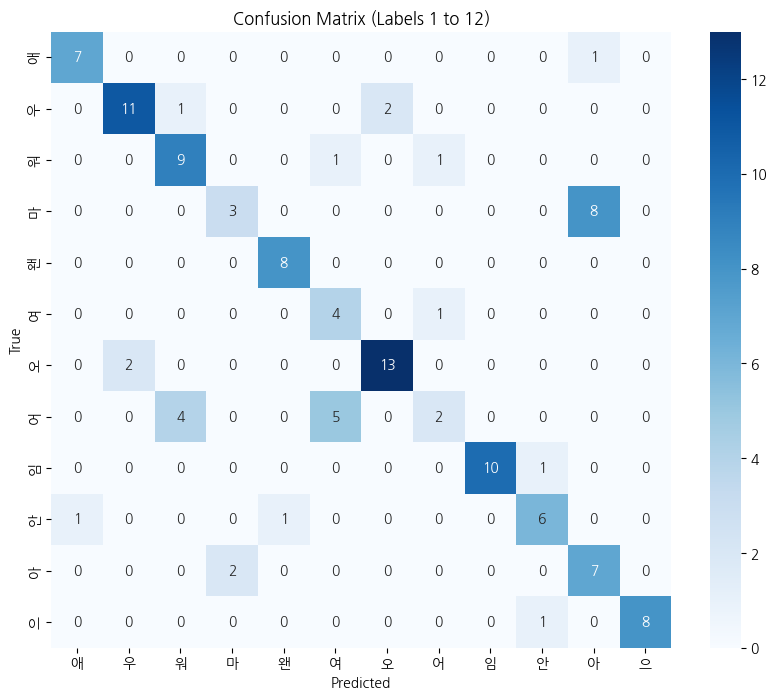

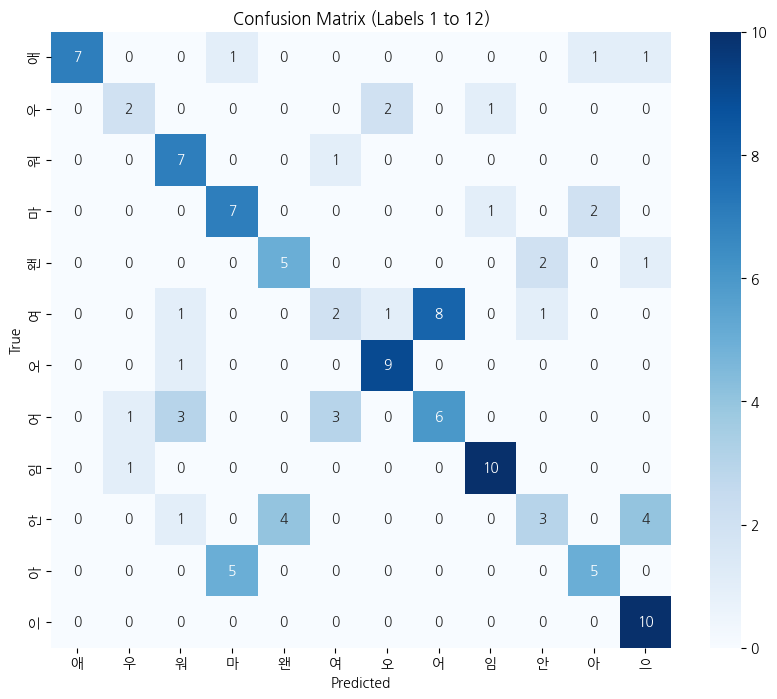

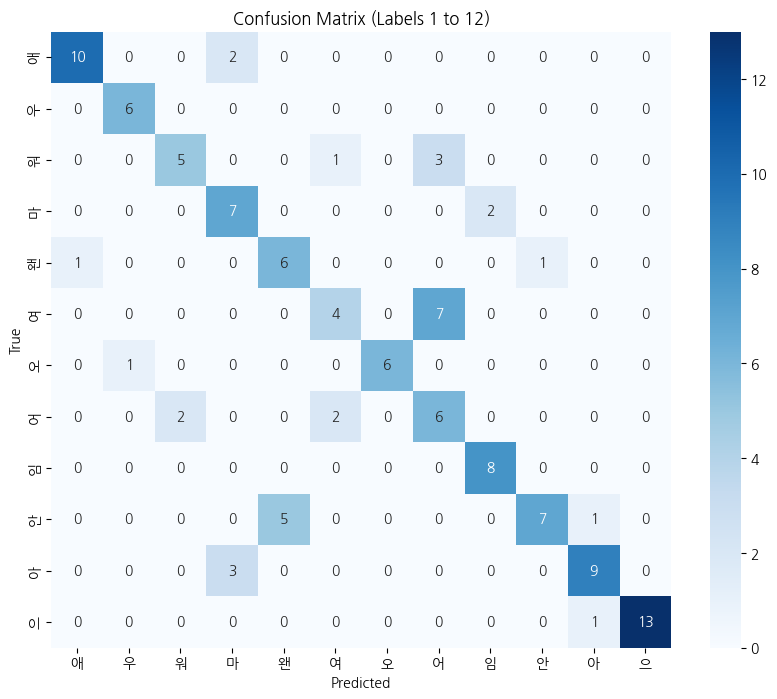

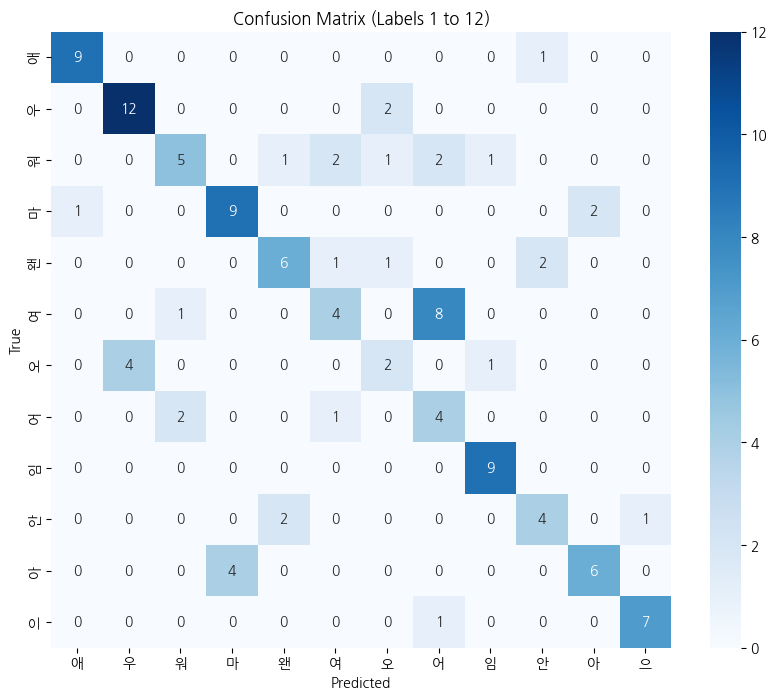

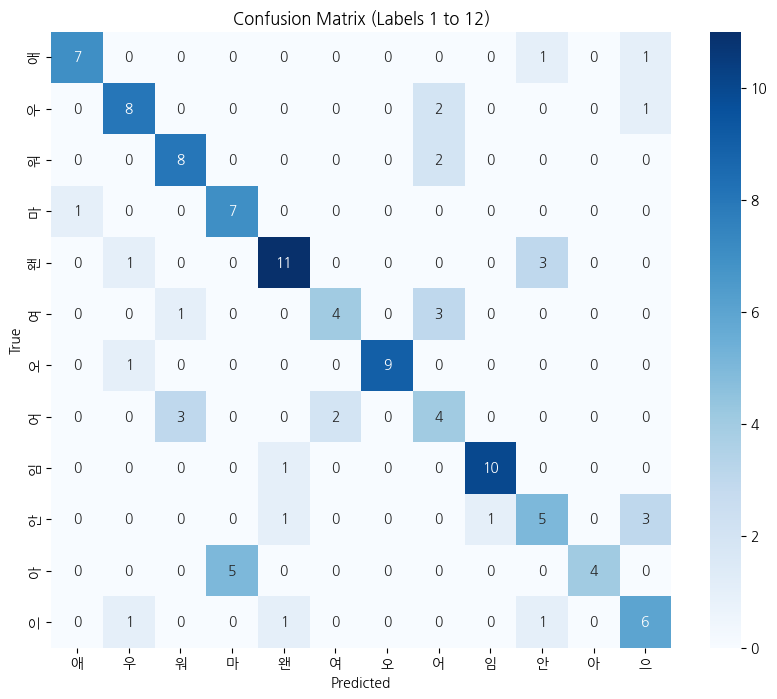

모든 폴드 학습 완료


In [13]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold

# 텐서보드 로그 디렉토리 설정
log_dir = 'runs/lip_reading_experiment'
writer = SummaryWriter(log_dir)

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

num_classes = len(label_to_idx)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f'Fold {fold+1}/{kf.n_splits}')
    
    # Create data loaders for current fold
    train_subset = torch.utils.data.Subset(full_dataset, train_idx)
    val_subset = torch.utils.data.Subset(full_dataset, val_idx)
    
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=2)
    
    # Initialize model, loss function, and optimizer
    model = MobileNetV2LSTM(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    
    # Early stopping parameters
    num_epochs = 100
    patience = 5
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        model.train()
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), torch.tensor([label_to_idx[label] for label in labels], dtype=torch.long).to(device)
            outputs = model(images)
            loss = criterion(
                outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Validation step
        model.eval()
        val_epoch_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), torch.tensor([label_to_idx[label] for label in val_labels], dtype=torch.long).to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_epoch_loss += val_loss.item()
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        # 텐서보드에 기록
        writer.add_scalar(f'Fold_{fold+1}/Train_Loss', avg_train_loss, epoch)
        writer.add_scalar(f'Fold_{fold+1}/Train_Accuracy', train_accuracy, epoch)
        writer.add_scalar(f'Fold_{fold+1}/Val_Loss', avg_val_loss, epoch)
        writer.add_scalar(f'Fold_{fold+1}/Val_Accuracy', val_accuracy, epoch)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping")
                break
    
    # Model evaluation on validation set
    accuracy, cm, all_preds, all_labels = evaluate_model(model, val_loader, label_to_idx, num_classes)
    print(f'Fold {fold+1} Validation Accuracy: {accuracy:.4f}')
    
    fold_results.append((accuracy, cm))

# Aggregate fold results
mean_accuracy = np.mean([result[0] for result in fold_results])
print(f'Mean Validation Accuracy: {mean_accuracy:.4f}')

# Plot confusion matrices for each fold
for fold, (_, cm) in enumerate(fold_results):
    plot_confusion_matrix_in_chunks(cm, idx_to_label)

# 모델 저장
torch.save(model.state_dict(), 'lip_reading_model.pth')

# 텐서보드 종료
writer.close()

print("모든 폴드 학습 완료")


In [14]:
test_val_dir = 'dataset/testset'

test_val_set = LipReadingDataset(test_val_dir, transform=val_transform)
test_val_loader = DataLoader(test_val_set, batch_size=4, shuffle=False, num_workers=4)

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 12/12 [00:00<00:00, 33.03it/s]


Accuracy: 0.7083


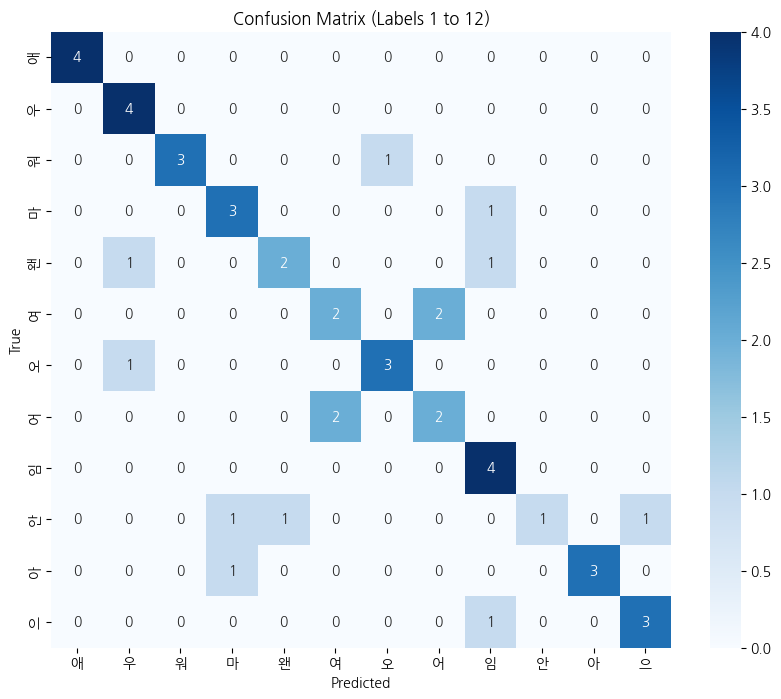

Predictions and Actual Labels:
Sample 1: Predicted: 왠, Actual: 안
Sample 1: Predicted: 왠, Actual: 안
Sample 2: Predicted: 으, Actual: 안
Sample 2: Predicted: 으, Actual: 안
Sample 3: Predicted: 마, Actual: 안
Sample 3: Predicted: 마, Actual: 안
Sample 4: Predicted: 안, Actual: 안
Sample 4: Predicted: 안, Actual: 안
Sample 5: Predicted: 오, Actual: 오
Sample 5: Predicted: 오, Actual: 오
Sample 6: Predicted: 오, Actual: 오
Sample 6: Predicted: 오, Actual: 오
Sample 7: Predicted: 우, Actual: 오
Sample 7: Predicted: 우, Actual: 오
Sample 8: Predicted: 오, Actual: 오
Sample 8: Predicted: 오, Actual: 오
Sample 9: Predicted: 워, Actual: 워
Sample 9: Predicted: 워, Actual: 워
Sample 10: Predicted: 워, Actual: 워
Sample 10: Predicted: 워, Actual: 워
Sample 11: Predicted: 워, Actual: 워
Sample 11: Predicted: 워, Actual: 워
Sample 12: Predicted: 오, Actual: 워
Sample 12: Predicted: 오, Actual: 워
Sample 13: Predicted: 애, Actual: 애
Sample 13: Predicted: 애, Actual: 애
Sample 14: Predicted: 애, Actual: 애
Sample 14: Predicted: 애, Actual: 애
Sample 

In [15]:
# 평가 함수 정의
def evaluate_model(model, dataloader, label_to_idx, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    unknown_label_idx = num_classes  # Unknown label index
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = [label_to_idx.get(label, unknown_label_idx) for label in labels]  # Unknown label handling
            valid_indices = [i for i, label in enumerate(labels) if label != unknown_label_idx]
            
            if valid_indices:  # 유효한 인덱스가 있을 때만 평가
                images = images[valid_indices]
                labels = torch.tensor([label for label in labels if label != unknown_label_idx], dtype=torch.long).to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
    if all_labels and all_preds:
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    else:
        accuracy = 0.0
        cm = np.zeros((num_classes, num_classes), dtype=int)
    
    return accuracy, cm, all_preds, all_labels

# 혼동 행렬을 20개의 라벨씩 나누는 함수 정의
def plot_confusion_matrix_in_chunks(cm, idx_to_label, chunk_size=20):
    labels = list(idx_to_label.values())
    num_labels = len(labels)
    
    for i in range(0, num_labels, chunk_size):
        chunk_labels = labels[i:i+chunk_size]
        chunk_cm = cm[i:i+chunk_size, i:i+chunk_size]
        
        if chunk_cm.size > 0:  # chunk_cm이 비어있지 않을 때만 시각화
            plt.figure(figsize=(10, 8))
            sns.heatmap(chunk_cm, annot=True, fmt='d', cmap='Blues', xticklabels=chunk_labels, yticklabels=chunk_labels)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix (Labels {i+1} to {i+len(chunk_labels)})')
            plt.show()

# 모델 평가
num_classes = len(label_to_idx)
accuracy, cm, all_preds, all_labels = evaluate_model(model, test_val_loader, label_to_idx, num_classes)
print(f'Accuracy: {accuracy:.4f}')

# 혼동 행렬 시각화
plot_confusion_matrix_in_chunks(cm, idx_to_label)

# 각 클래스별 정확도 계산 및 출력
with np.errstate(divide='ignore', invalid='ignore'):
    class_accuracy = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))

#for idx, acc in enumerate(class_accuracy):
 #   print(f'Accuracy for class {idx_to_label[idx]}: {acc:.4f}')

# 모델의 예측과 실제 라벨 출력
print("Predictions and Actual Labels:")
for i, (pred, actual) in enumerate(zip(all_preds, all_labels)):
    print(f"Sample {i+1}: Predicted: {idx_to_label[pred]}, Actual: {idx_to_label[actual]}")

# 모델의 출력 확인rate(zip(all_preds, all_labels)):
    print(f"Sample {i+1}: Predicted: {idx_to_label[pred]}, Actual: {idx_to_label[actual]}")

# 모델의 출력 확인
with torch.no_grad():
    output = model(sample.unsqueeze(0).to(device))
    _, pred = torch.max(output, 1)
    pred_label = idx_to_label[pred.item()]
    actual_label = label

print(f"Predicted label: {pred_label}, Actual label: {actual_label}")

# 혼동 행렬 및 예측 결과 저장
np.save('confusion_matrix.npy', cm)
np.save('all_preds.npy', np.array(all_preds))
np.save('all_labels.npy', np.array(all_labels))